In [69]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = (12, 5)

                    count  mean   std   min   25%   50%   75%   max
acousticness      13129.0  0.52  0.38  0.00  0.10  0.57  0.92  1.00
danceability      13129.0  0.49  0.19  0.05  0.34  0.49  0.63  0.97
energy            13129.0  0.54  0.28  0.00  0.32  0.55  0.78  1.00
instrumentalness  13129.0  0.64  0.36  0.00  0.32  0.84  0.92  1.00
liveness          13129.0  0.19  0.16  0.03  0.10  0.12  0.21  0.98
speechiness       13129.0  0.10  0.14  0.02  0.04  0.05  0.09  0.97
valence           13129.0  0.44  0.28  0.00  0.20  0.42  0.67  1.00


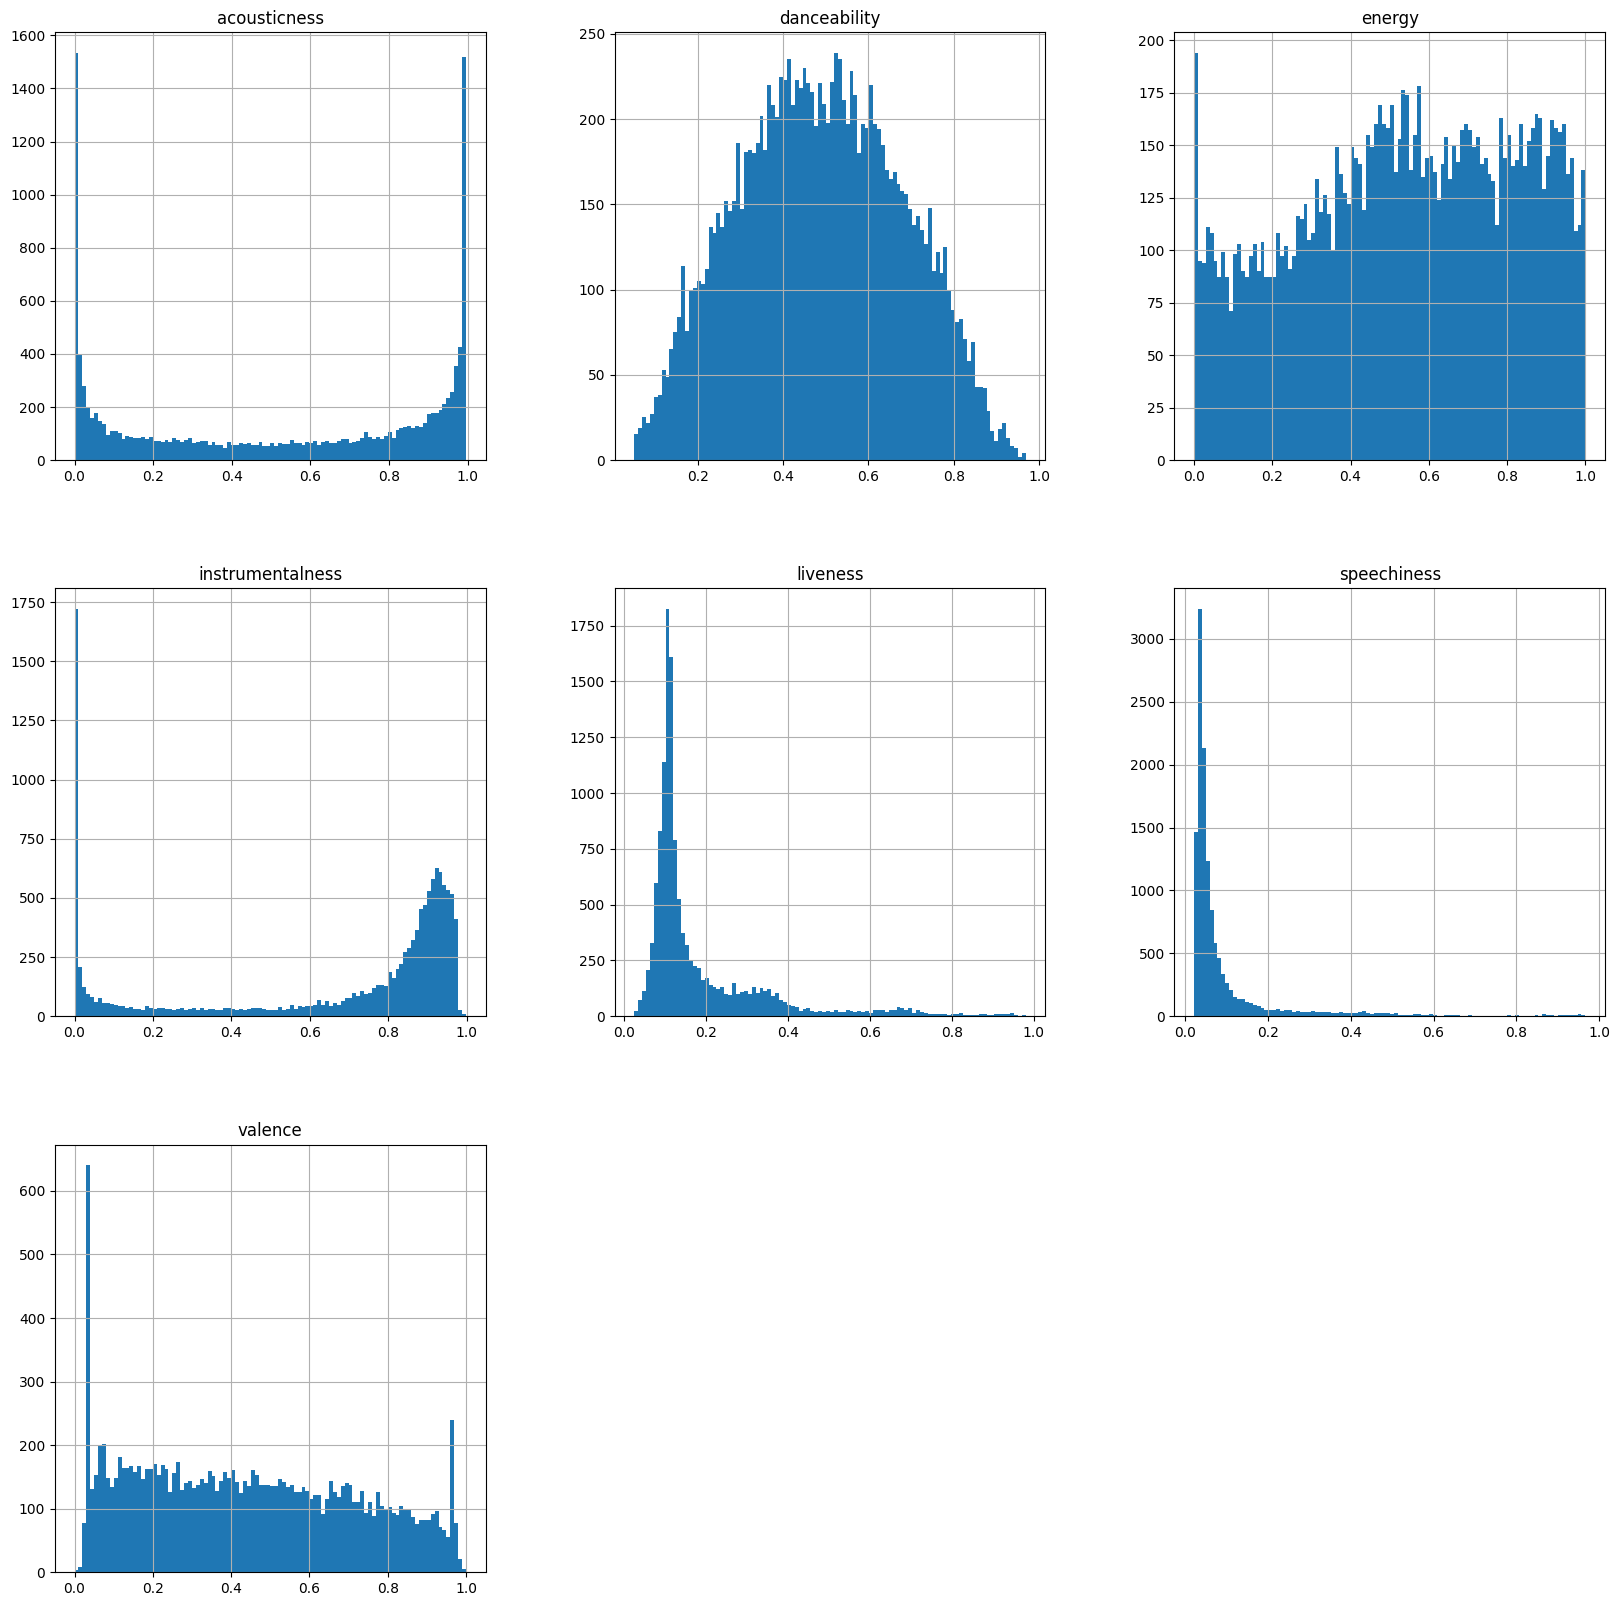

In [80]:
# extract the features from the echonest file
base_dir = '../A4/fma_metadata'  # change this to your own directory
echonest_raw = pd.read_csv(f'{base_dir}/echonest.csv', index_col=0, header=[0, 1, 2])

# extract only the target features
echonest_features = echonest_raw['echonest', 'audio_features']

# drop tempo (will be a model input not target)
echonest_features.drop('tempo', axis=1, inplace=True)

# print histogram to see the distribution of values
echonest_features.hist(bins=100, figsize=(20, 20));

print(echonest_features.describe().T.round(2))

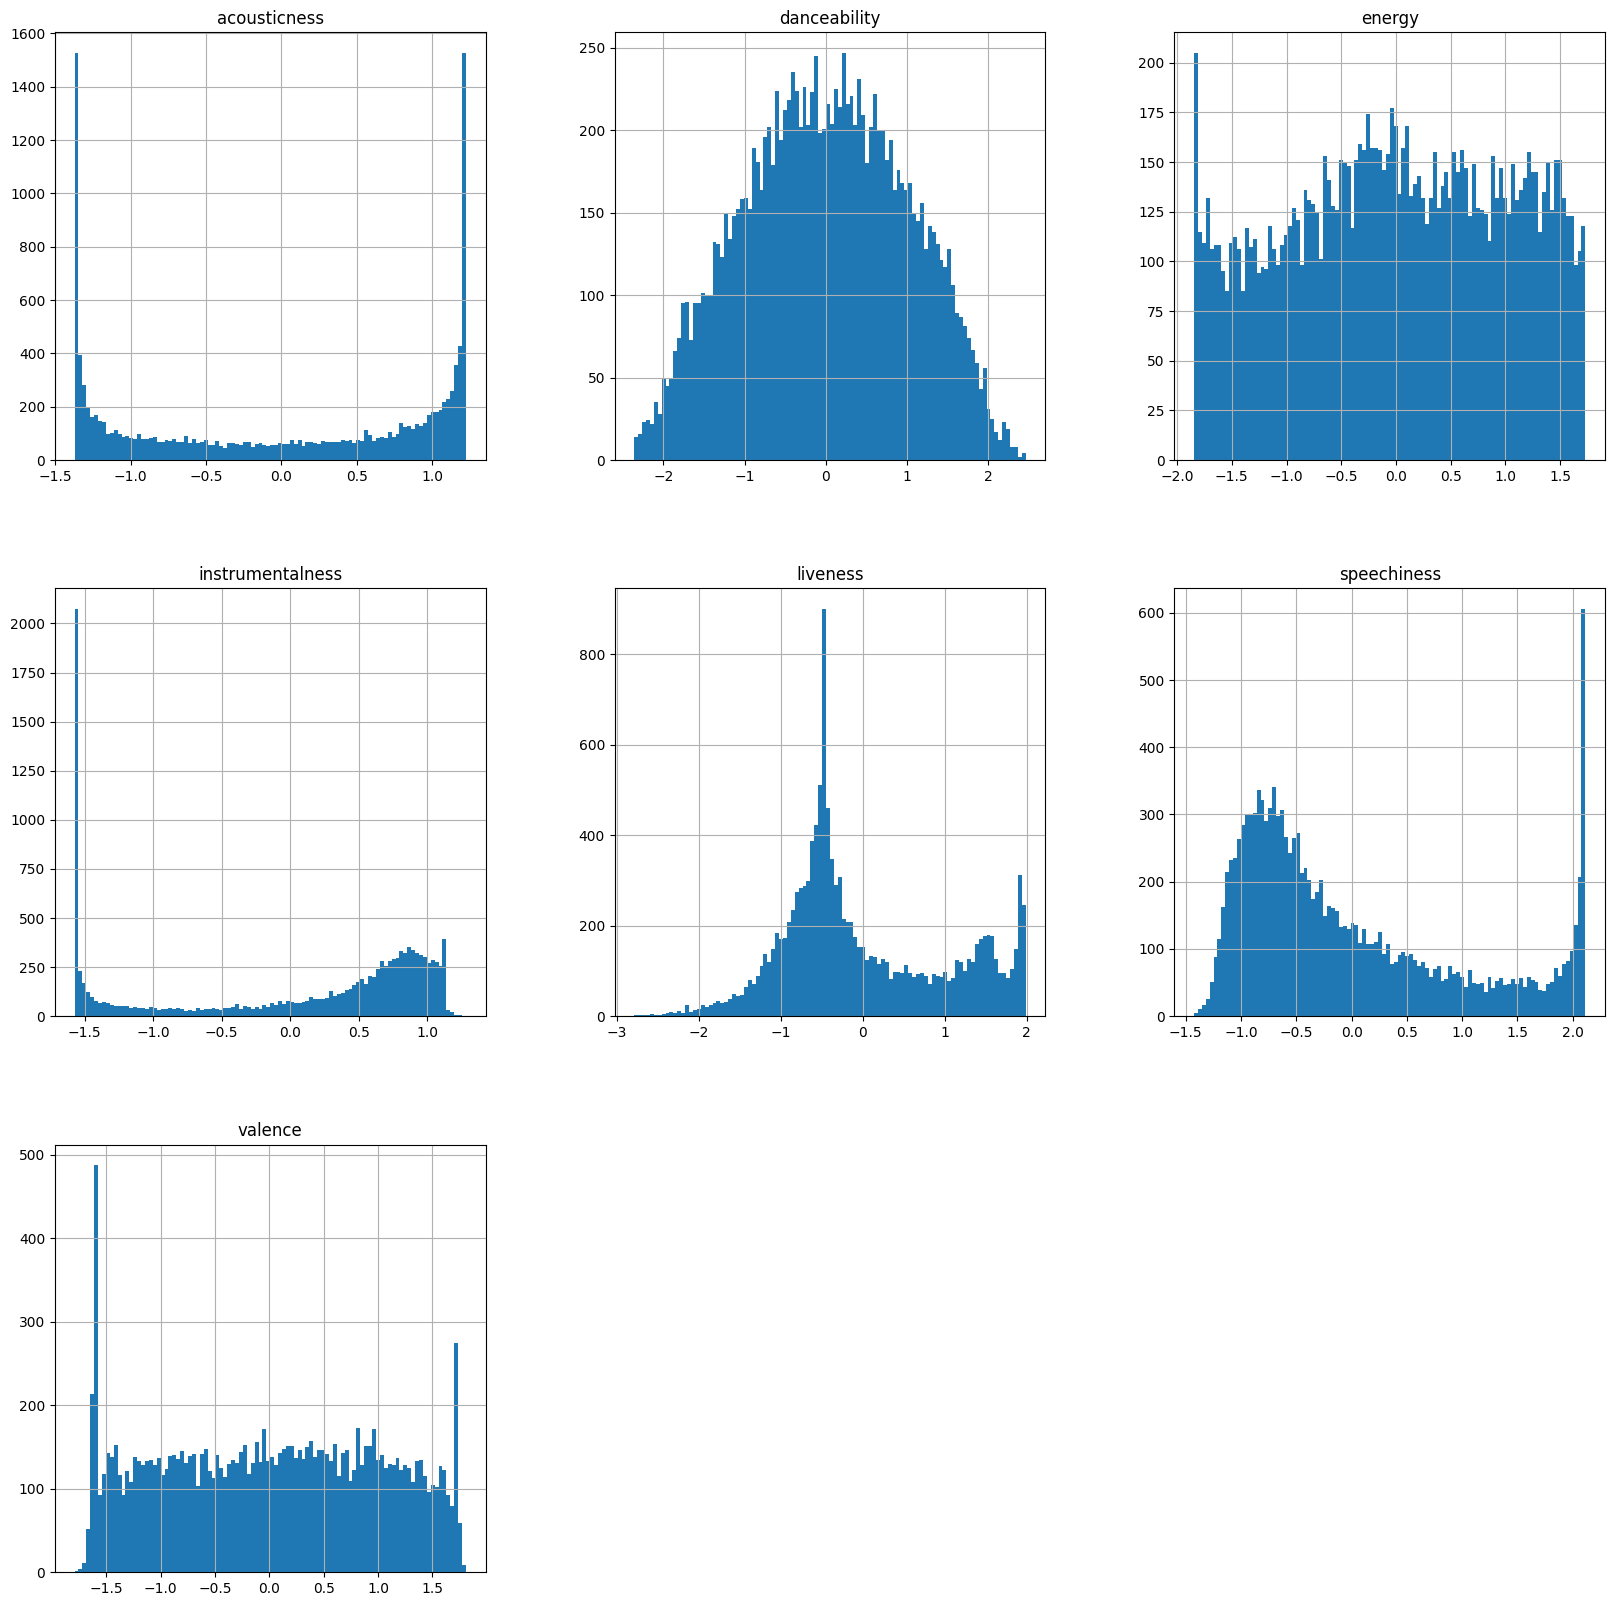

In [83]:
# log scale the echonest features to make them more normally distributed
pt = PowerTransformer()
en_feats_logscale = pd.DataFrame(pt.fit_transform(echonest_features),
                                 columns=echonest_features.columns,
                                 index=echonest_features.index)

en_feats_logscale.hist(bins=100, figsize=(20, 20));

In [84]:
# convert echonest features to binary targets by thresholding at mean + coeff * std
coeff = 0.1
binary_targets = en_feats_logscale.apply(lambda x: (x > x.mean() + coeff*x.std()).astype(int), axis=0)

print(binary_targets.describe().T.round(2))

                    count  mean   std  min  25%  50%  75%  max
acousticness      13129.0  0.51  0.50  0.0  0.0  1.0  1.0  1.0
danceability      13129.0  0.47  0.50  0.0  0.0  0.0  1.0  1.0
energy            13129.0  0.47  0.50  0.0  0.0  0.0  1.0  1.0
instrumentalness  13129.0  0.60  0.49  0.0  0.0  1.0  1.0  1.0
liveness          13129.0  0.36  0.48  0.0  0.0  0.0  1.0  1.0
speechiness       13129.0  0.35  0.48  0.0  0.0  0.0  1.0  1.0
valence           13129.0  0.48  0.50  0.0  0.0  0.0  1.0  1.0


In [94]:
# save the binary targets to a csv file
EN_feature_mapping = {
    "acousticness": "acoustic",
    "danceability": "danceable",
    "energy": "energetic",
    "instrumentalness": "instrumental",
    "liveness": "lively",
    "speechiness": "speechy",
    "valence": "happy"
}
binary_targets.rename(columns=EN_feature_mapping, inplace=True)
binary_targets.to_csv('echonest-simple.csv')

In [87]:
# Get list of audio track file paths
base_dir = '../A4/fma_smaller'  # change this to your own path
fnames = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            fnames.append(file_path)

print(fnames[:5])

['../A4/fma_smaller/Hip-Hop/006608.wav', '../A4/fma_smaller/Hip-Hop/098550.wav', '../A4/fma_smaller/Hip-Hop/014542.wav', '../A4/fma_smaller/Hip-Hop/098578.wav', '../A4/fma_smaller/Hip-Hop/037416.wav']


In [113]:
tag_df = pd.read_csv('echonest-simple.csv', index_col='track_id')

features_mean_mfcc = []
features_mean_std_mfcc = []
features_mean_chroma = []
features_mean_std_chroma = []
features_tempo = []
targets = []  # genre and echonest tags

total = 0
skipped = 0
genre_count = {}

# Iterate over audio files to extract features (model inputs) and targets/labels
for idx, fname in enumerate(fnames):
    total += 1

    # Check if the track ID is in tag_df
    track_id = int(os.path.basename(fname).split(".")[0])
    match = tag_df[tag_df.index == track_id]
    if match.empty:
        skipped += 1
        continue
    
    # Target for a track = genre + echonest tags
    echonest_tags = match.values.tolist()[0]
    genre = fname.split(os.sep)[-2]
    genre_count[genre] = genre_count.get(genre, 0) + 1
    targets.append(np.hstack([genre] + echonest_tags))

    # Load the audio file and extract the features
    print(f'Extracting features for track {idx}', end='\r')
    audio, srate = librosa.load(fname, res_type='kaiser_fast')
    mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate, n_mfcc=40)
    chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=srate)
    tempo, _ = librosa.beat.beat_track(y=audio, sr=srate)

    mean_mfcc = np.mean(mfcc_matrix, axis=1)
    std_mfcc = np.std(mfcc_matrix, axis=1)
    mean_chroma = np.mean(chroma_cqt, axis=1)
    std_chroma = np.std(chroma_cqt, axis=1)

    features_mean_mfcc.append(mean_mfcc)
    features_mean_std_mfcc.append(std_mfcc)
    features_mean_chroma.append(mean_chroma)
    features_mean_std_chroma.append(std_chroma)
    features_tempo.append(tempo)

print(f"\nSkipped {skipped}/{total} files")
print(f"Dataset size: {len(features_mean_mfcc)}")
print(f"Genre count: {genre_count}")

Extracting features for track 3988
Skipped 3179/3998 files
Dataset size: 819
Genre count: {'Hip-Hop': 244, 'Instrumental': 52, 'Rock': 233, 'Folk': 290}


In [118]:
X_mean_mfcc = np.array(features_mean_mfcc)
X_mean_std_mfcc = np.array(features_mean_std_mfcc)
X_mean_chroma = np.array(features_mean_chroma)
X_mean_std_chroma = np.array(features_mean_std_chroma)
X_mean_mfcc_chroma = np.hstack([X_mean_mfcc, X_mean_chroma])
X_tempo = np.array(features_tempo).reshape(-1, 1)
X_mean_mfcc_tempo = np.hstack([X_mean_mfcc, X_tempo])
X_all = np.hstack([X_mean_mfcc, X_mean_std_mfcc, X_mean_chroma, X_mean_std_chroma, X_tempo])
y = np.array(targets)

# Print the shape of the features and targets
print(f"mean_mfcc shape: {X_mean_mfcc.shape}")
print(f"mean_std_mfcc shape: {X_mean_std_mfcc.shape}")
print(f"mean_chroma shape: {X_mean_chroma.shape}")
print(f"mean_std_chroma shape: {X_mean_std_chroma.shape}")
print(f"mean_all shape: {X_mean_mfcc_chroma.shape}")
print(f"tempo shape: {X_tempo.shape}")
print(f"mean_mfcc_tempo shape: {X_mean_mfcc_tempo.shape}")
print(f"all shape: {X_all.shape}")
print(f"Targets shape: {y.shape}")

mean_mfcc shape: (819, 40)
mean_std_mfcc shape: (819, 40)
mean_chroma shape: (819, 12)
mean_std_chroma shape: (819, 12)
mean_all shape: (819, 52)
tempo shape: (819, 1)
mean_mfcc_tempo shape: (819, 41)
all shape: (819, 105)
Targets shape: (819, 8)


In [117]:
def eval_classifier(X, y, clf, target_names, test_size):
    """ Trains and runs a classifier on the given features and targets.
        Displays the confusion matrix and accuracy for each target/label.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    n_features = y.shape[1]
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten()

    accuracies = {}

    # Train and predict for each target/label
    for i in range(n_features):
        clf.fit(X_train, y_train[:, i])
        
        y_pred = clf.predict(X_test)
        
        cm = confusion_matrix(y_test[:, i], y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i])
        axes[i].set_title(f'Feature: {target_names[i]}')
        
        acc = accuracy_score(y_test[:, i], y_pred)
        accuracies[target_names[i]] = acc

    # Hide any unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(f"Feature Accuracies:")
    for feature, acc in accuracies.items():
        print(f"{feature}: {acc:.2f}")
    
    return accuracies


Evaluating Mean MFCC feature set using RandomForest classifier:


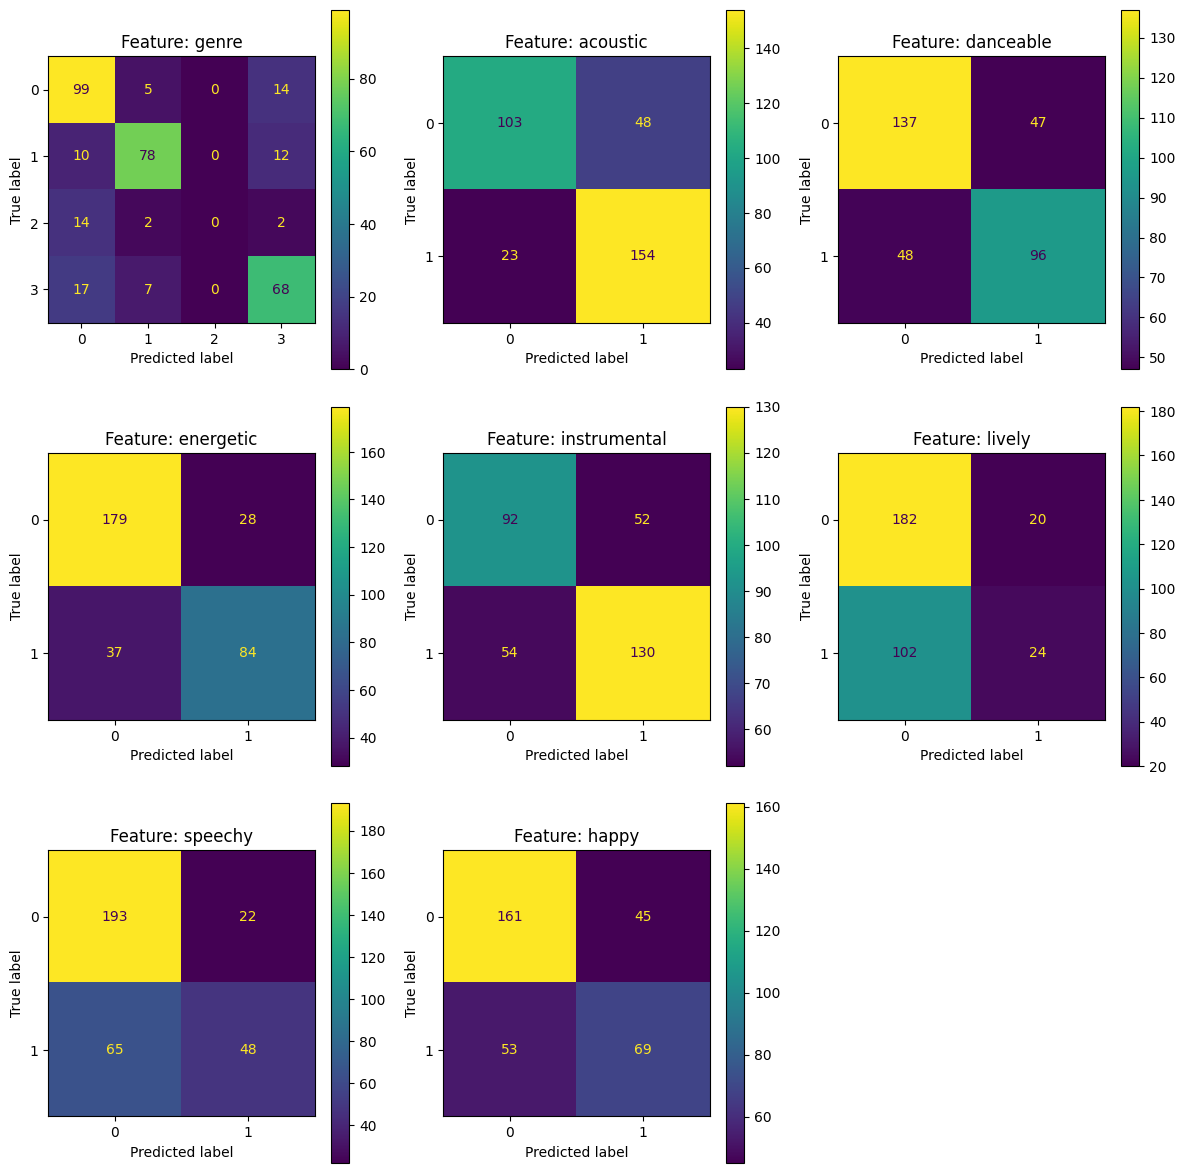

Feature Accuracies:
genre: 0.75
acoustic: 0.78
danceable: 0.71
energetic: 0.80
instrumental: 0.68
lively: 0.63
speechy: 0.73
happy: 0.70

Evaluating Mean & Std MFCC feature set using RandomForest classifier:


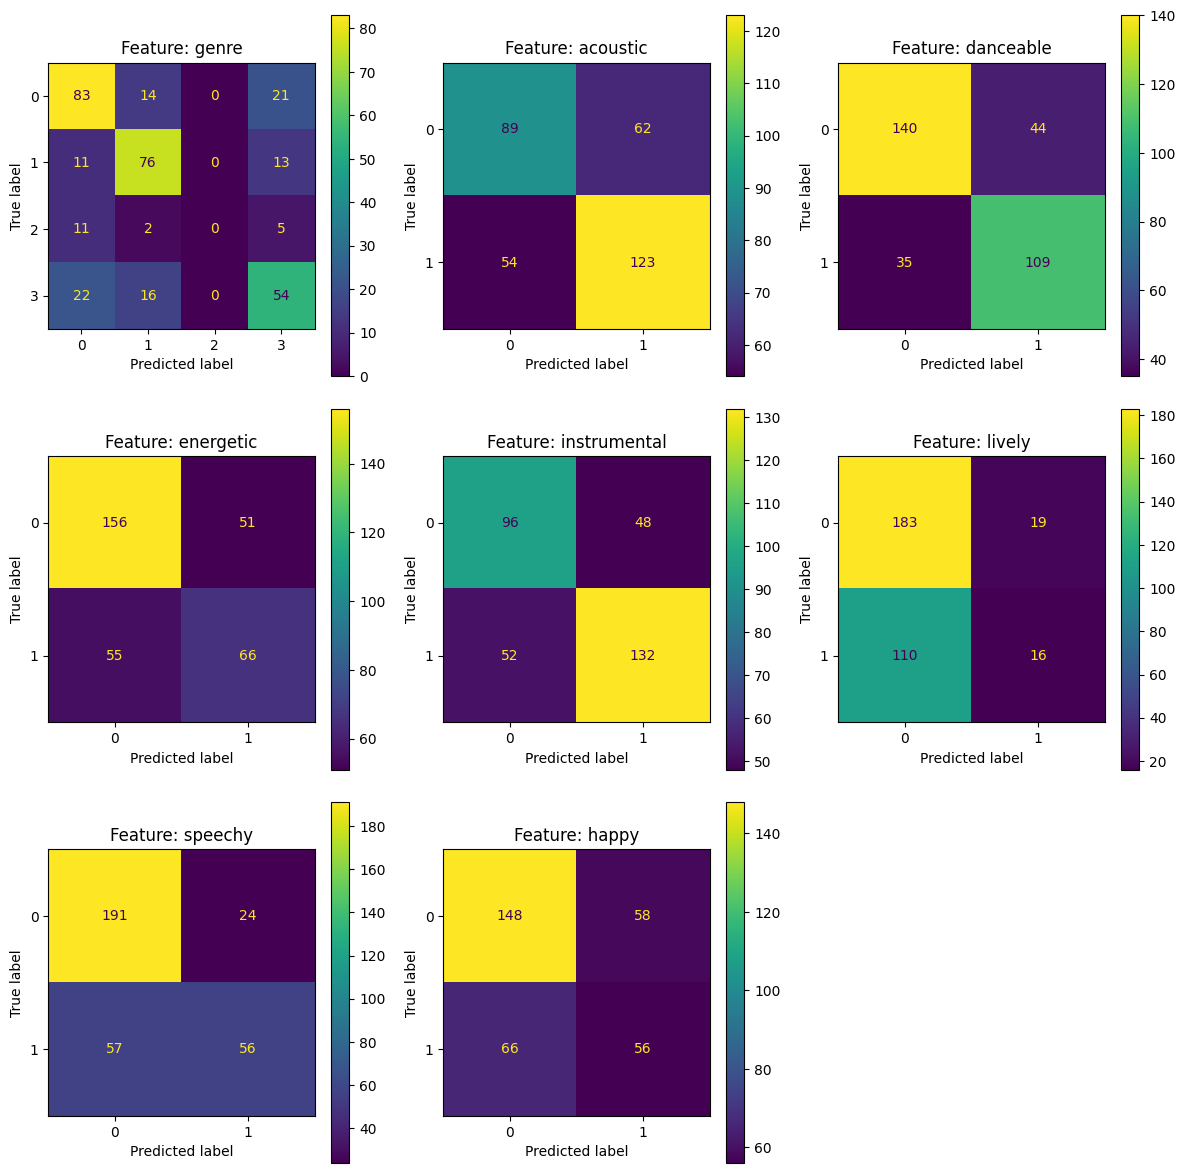

Feature Accuracies:
genre: 0.65
acoustic: 0.65
danceable: 0.76
energetic: 0.68
instrumental: 0.70
lively: 0.61
speechy: 0.75
happy: 0.62

Evaluating Mean Chroma feature set using RandomForest classifier:


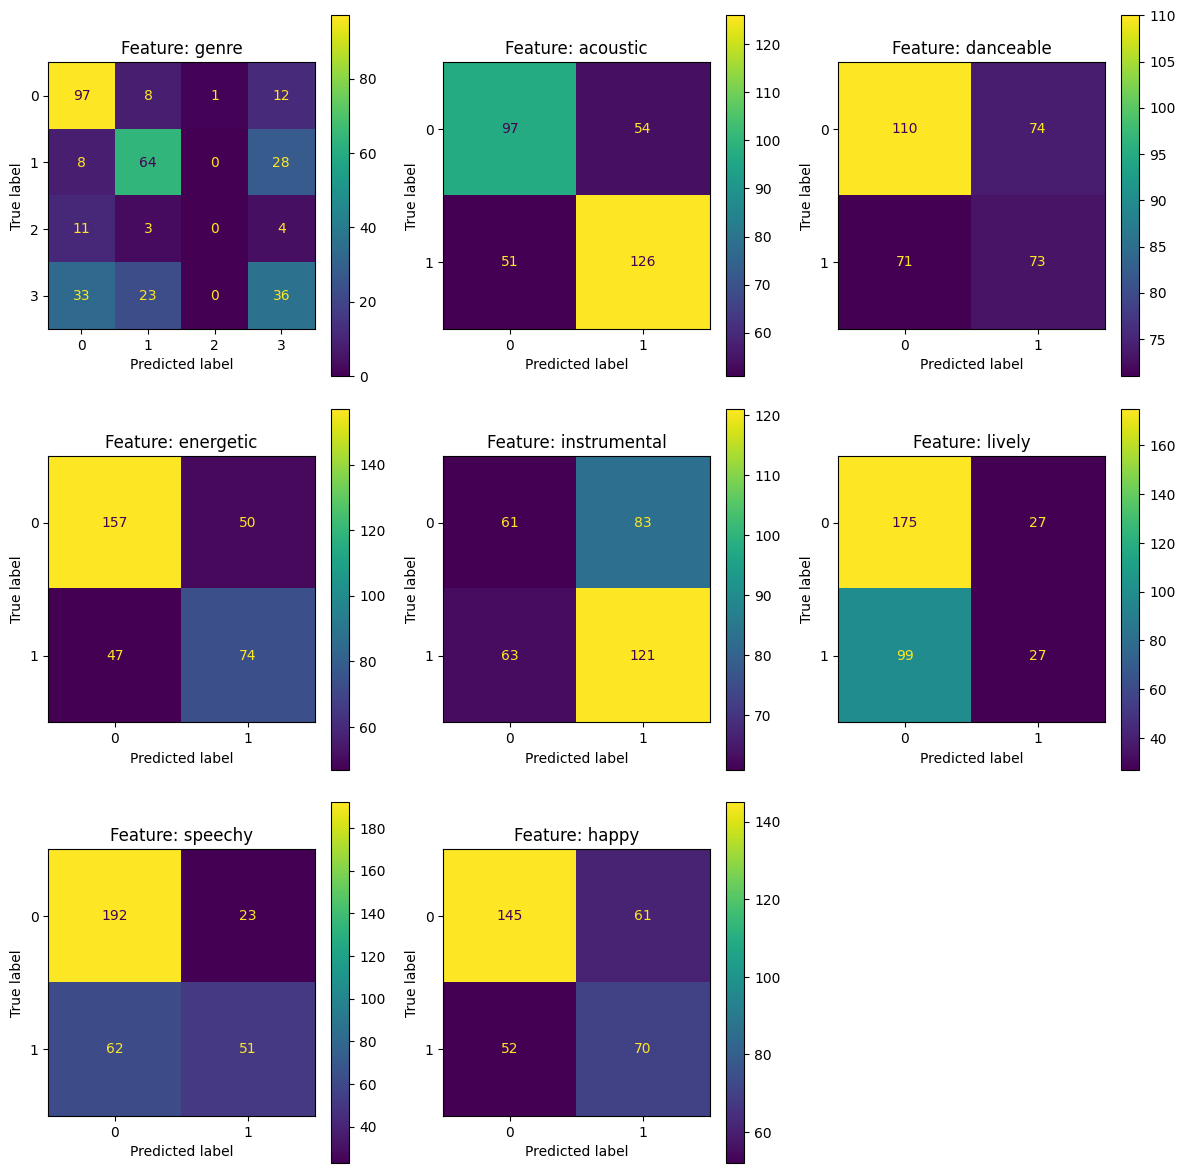

Feature Accuracies:
genre: 0.60
acoustic: 0.68
danceable: 0.56
energetic: 0.70
instrumental: 0.55
lively: 0.62
speechy: 0.74
happy: 0.66

Evaluating Mean & Std Chroma feature set using RandomForest classifier:


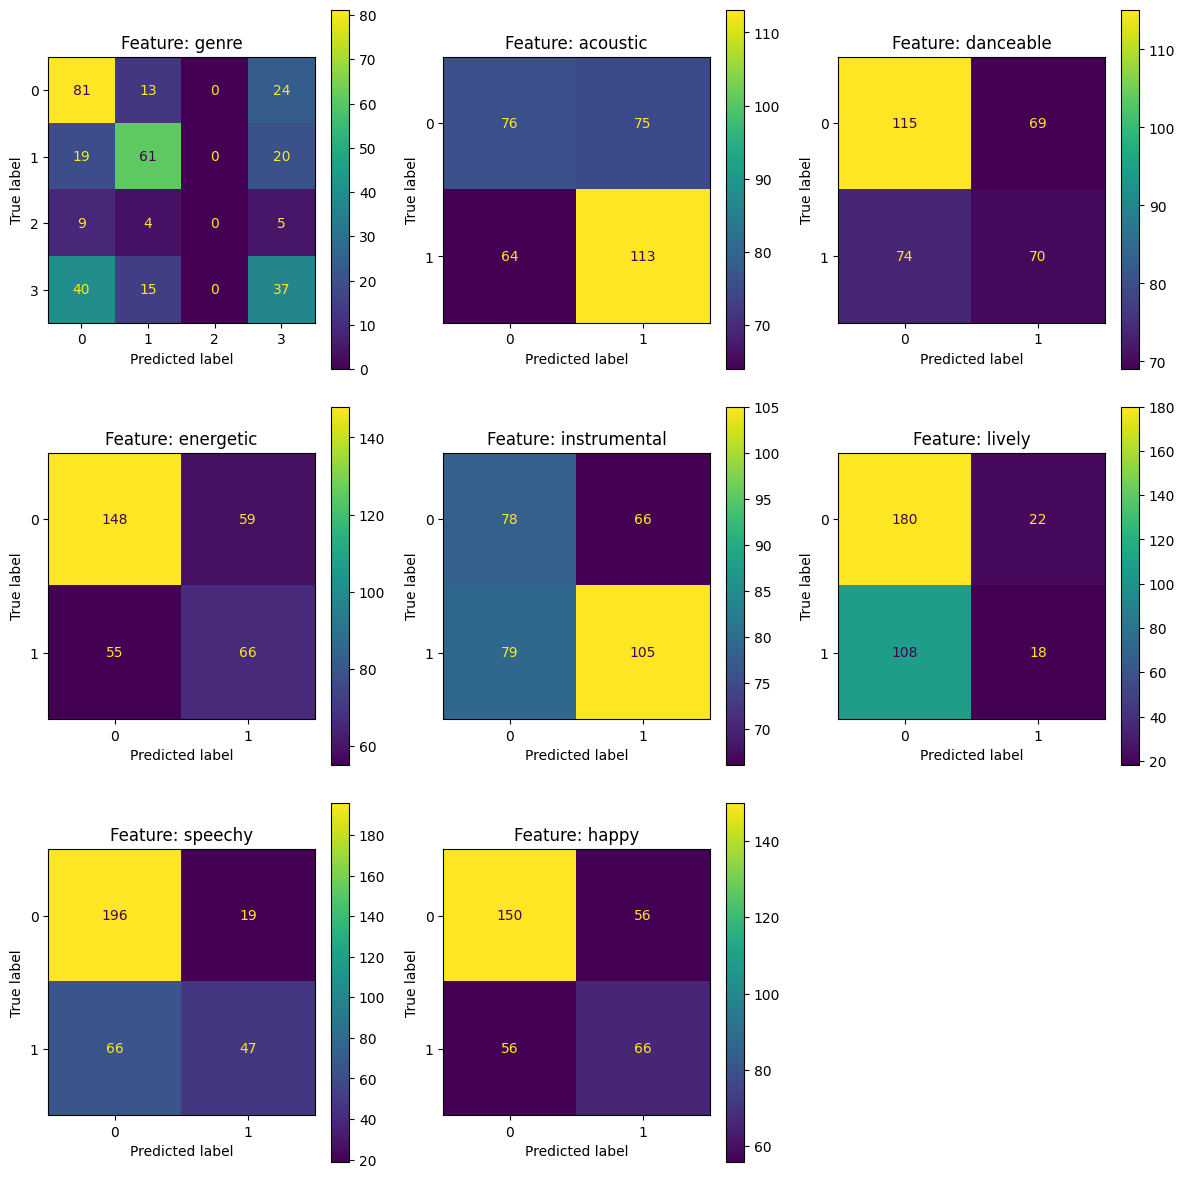

Feature Accuracies:
genre: 0.55
acoustic: 0.58
danceable: 0.56
energetic: 0.65
instrumental: 0.56
lively: 0.60
speechy: 0.74
happy: 0.66

Evaluating Mean MFCC & Chroma feature set using RandomForest classifier:


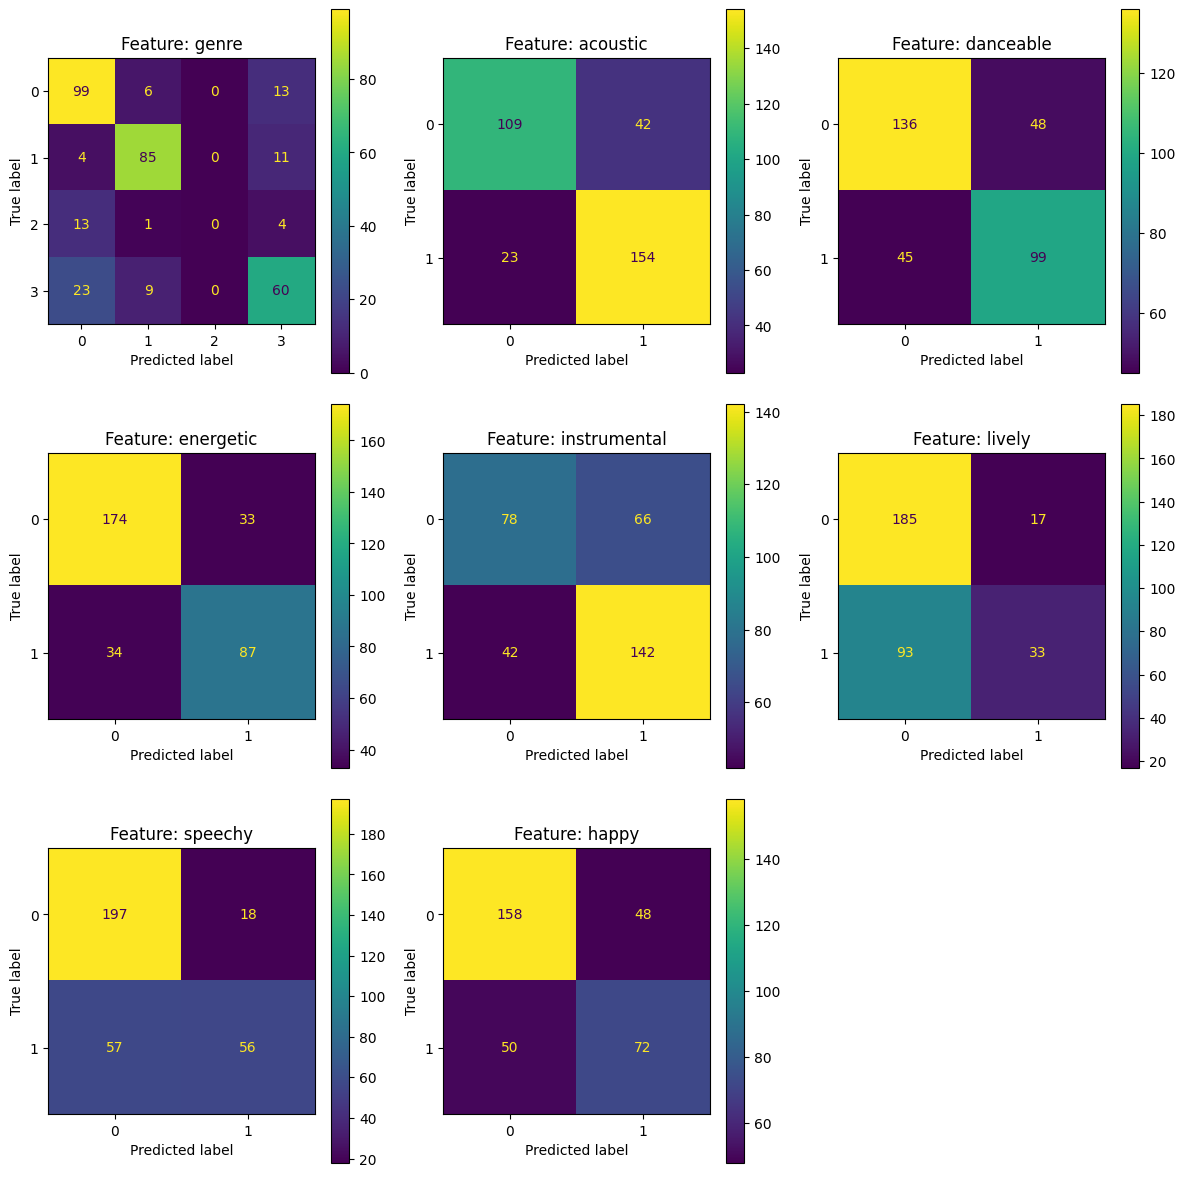

Feature Accuracies:
genre: 0.74
acoustic: 0.80
danceable: 0.72
energetic: 0.80
instrumental: 0.67
lively: 0.66
speechy: 0.77
happy: 0.70

Evaluating Tempo feature set using RandomForest classifier:


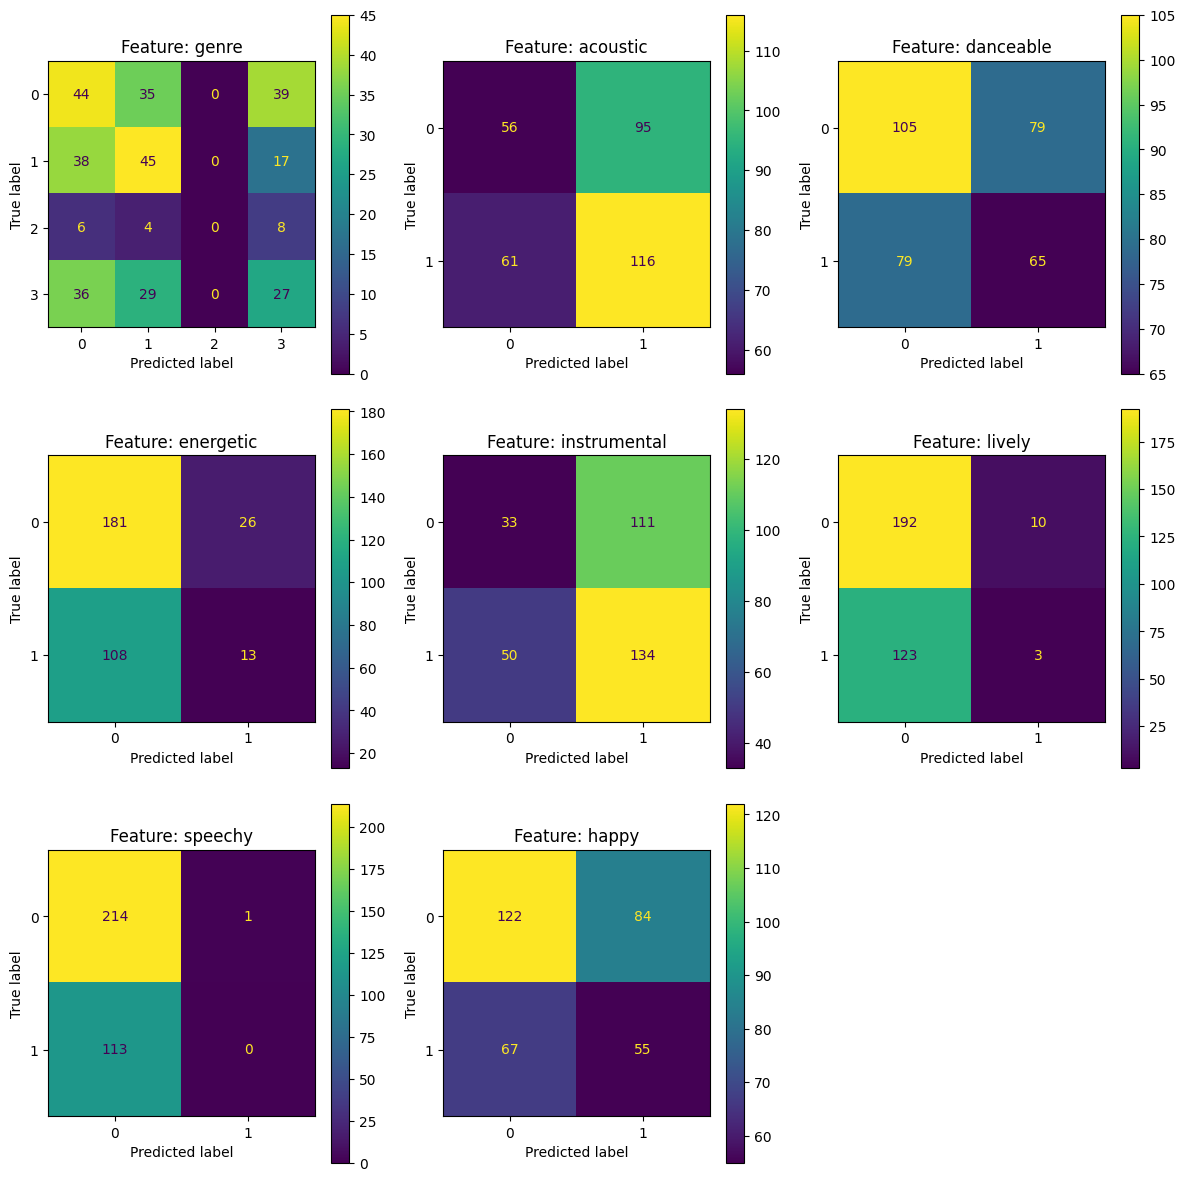

Feature Accuracies:
genre: 0.35
acoustic: 0.52
danceable: 0.52
energetic: 0.59
instrumental: 0.51
lively: 0.59
speechy: 0.65
happy: 0.54

Evaluating Mean MFCC & Tempo feature set using RandomForest classifier:


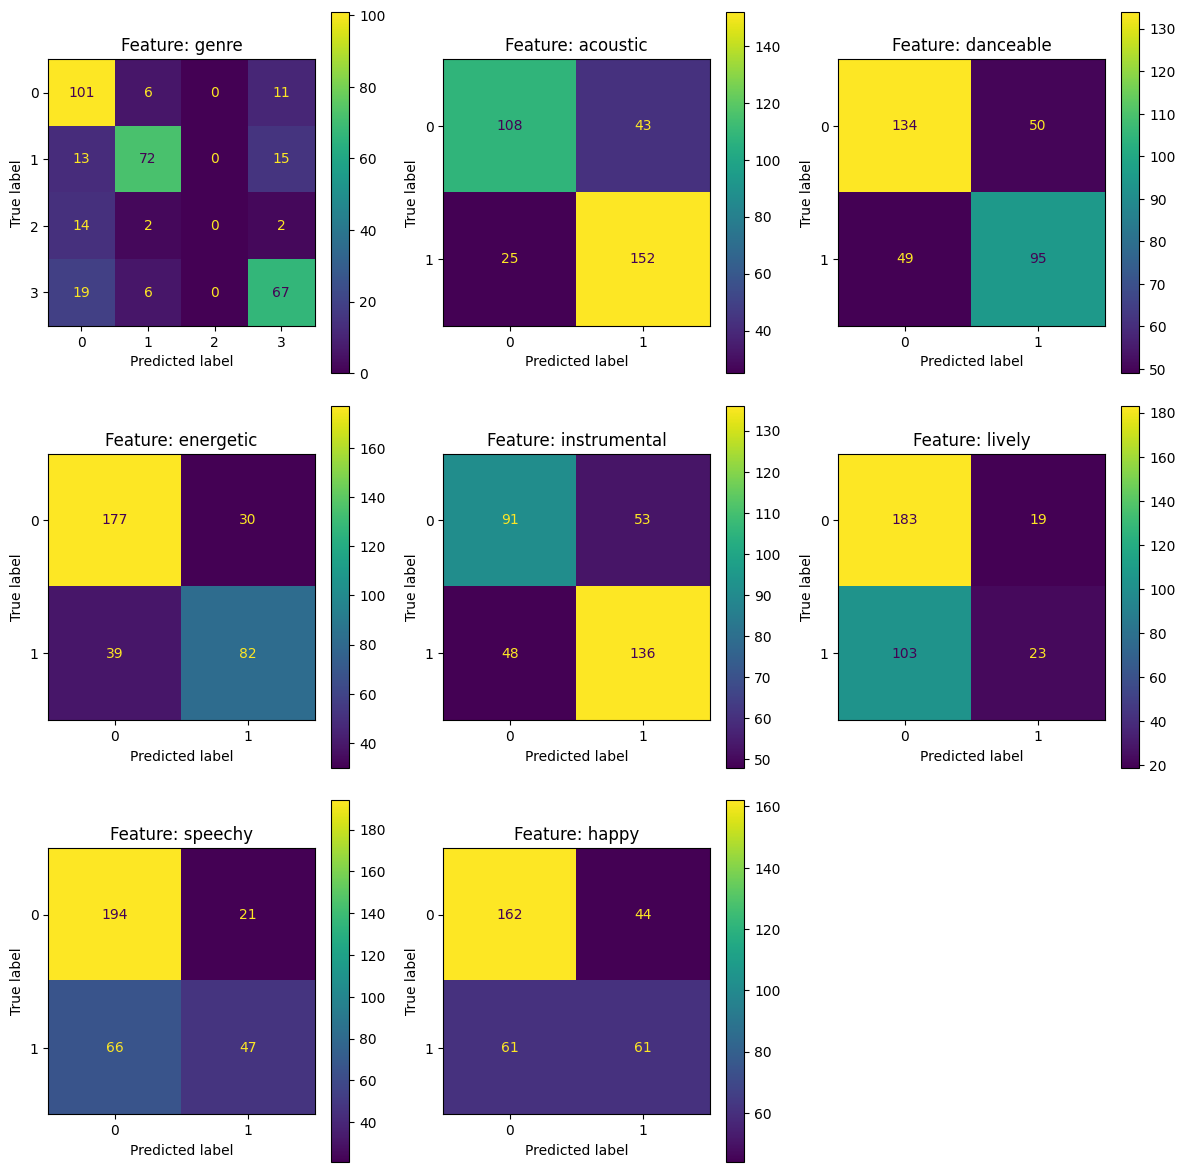

Feature Accuracies:
genre: 0.73
acoustic: 0.79
danceable: 0.70
energetic: 0.79
instrumental: 0.69
lively: 0.63
speechy: 0.73
happy: 0.68

Evaluating All Features feature set using RandomForest classifier:


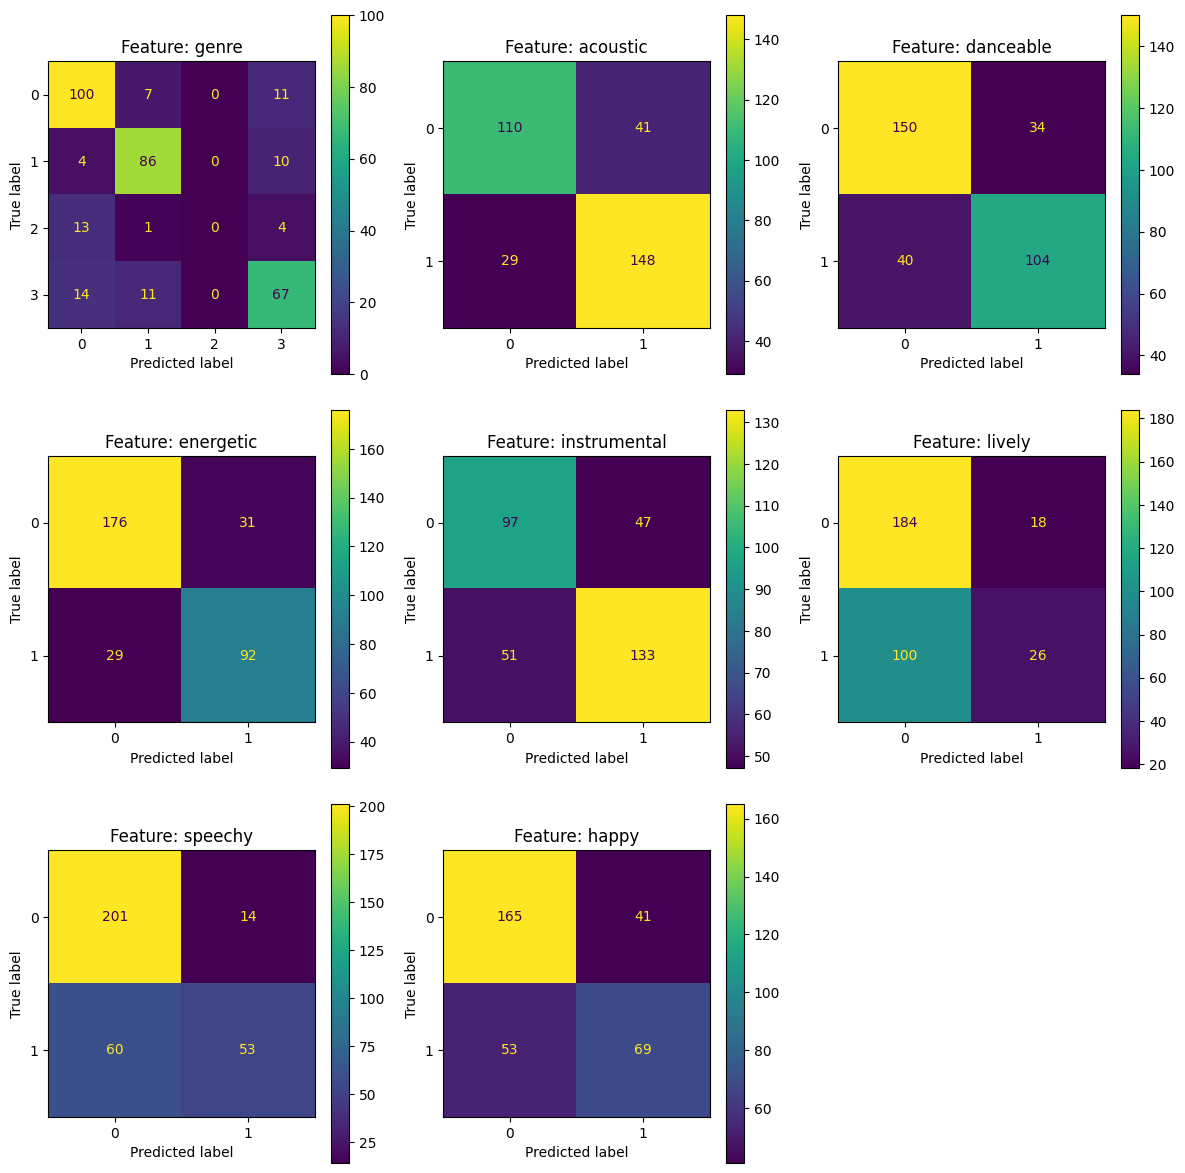

Feature Accuracies:
genre: 0.77
acoustic: 0.79
danceable: 0.77
energetic: 0.82
instrumental: 0.70
lively: 0.64
speechy: 0.77
happy: 0.71


In [121]:
# Evaluate random forest classifier using different feature sets
feature_sets = {
    'Mean MFCC': X_mean_mfcc,
    'Mean & Std MFCC': X_mean_std_mfcc,
    'Mean Chroma': X_mean_chroma,
    'Mean & Std Chroma': X_mean_std_chroma,
    'Mean MFCC & Chroma': X_mean_mfcc_chroma,
    'Tempo': X_tempo,
    'Mean MFCC & Tempo': X_mean_mfcc_tempo,
    'All Features': X_all,
}
target_names = ['genre'] + list(EN_feature_mapping.values())

classifier = RandomForestClassifier()

for feature_set, X in feature_sets.items():
    print(f"\nEvaluating {feature_set} feature set using RandomForest classifier:")
    eval_classifier(X, y, classifier, target_names, test_size=0.4)


Evaluating Mean MFCC feature set using Stratified Dummy classifier:


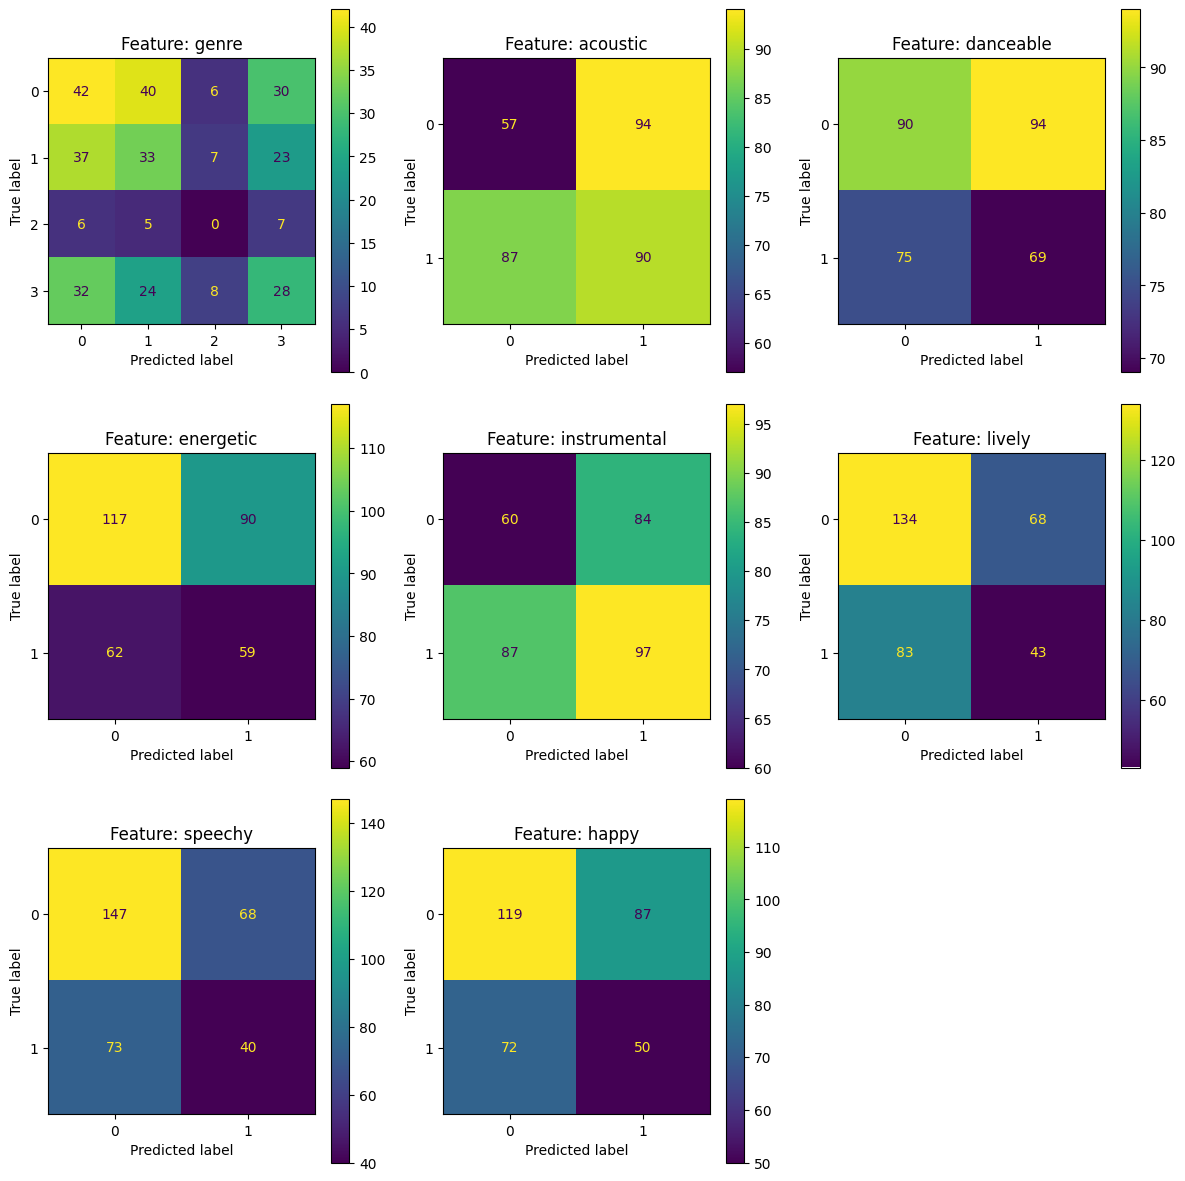

Feature Accuracies:
genre: 0.31
acoustic: 0.45
danceable: 0.48
energetic: 0.54
instrumental: 0.48
lively: 0.54
speechy: 0.57
happy: 0.52

Evaluating Mean & Std MFCC feature set using Stratified Dummy classifier:


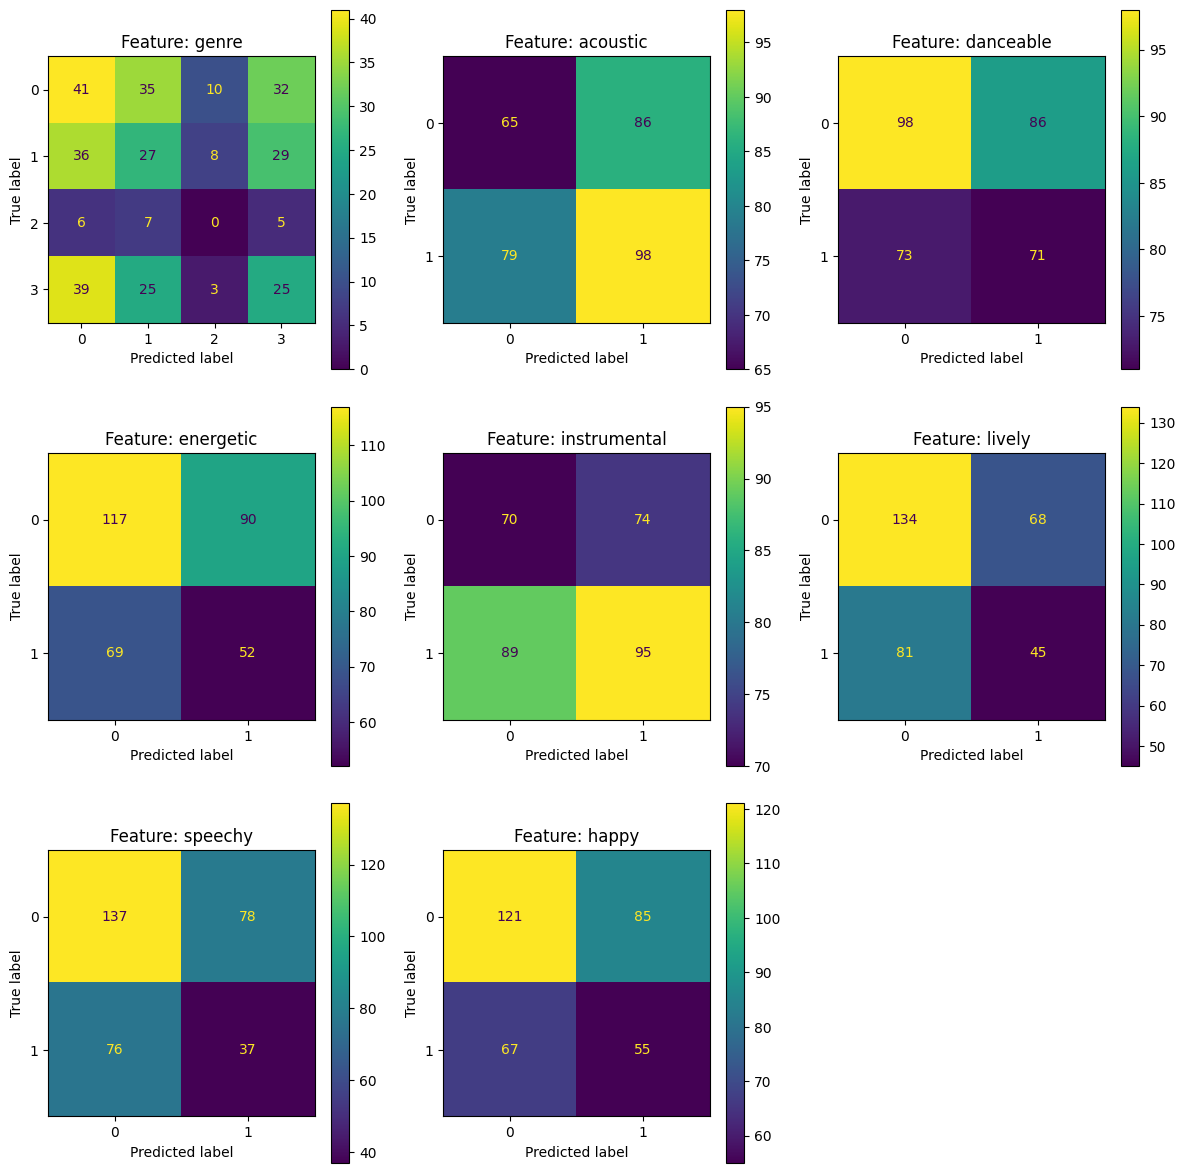

Feature Accuracies:
genre: 0.28
acoustic: 0.50
danceable: 0.52
energetic: 0.52
instrumental: 0.50
lively: 0.55
speechy: 0.53
happy: 0.54

Evaluating Mean Chroma feature set using Stratified Dummy classifier:


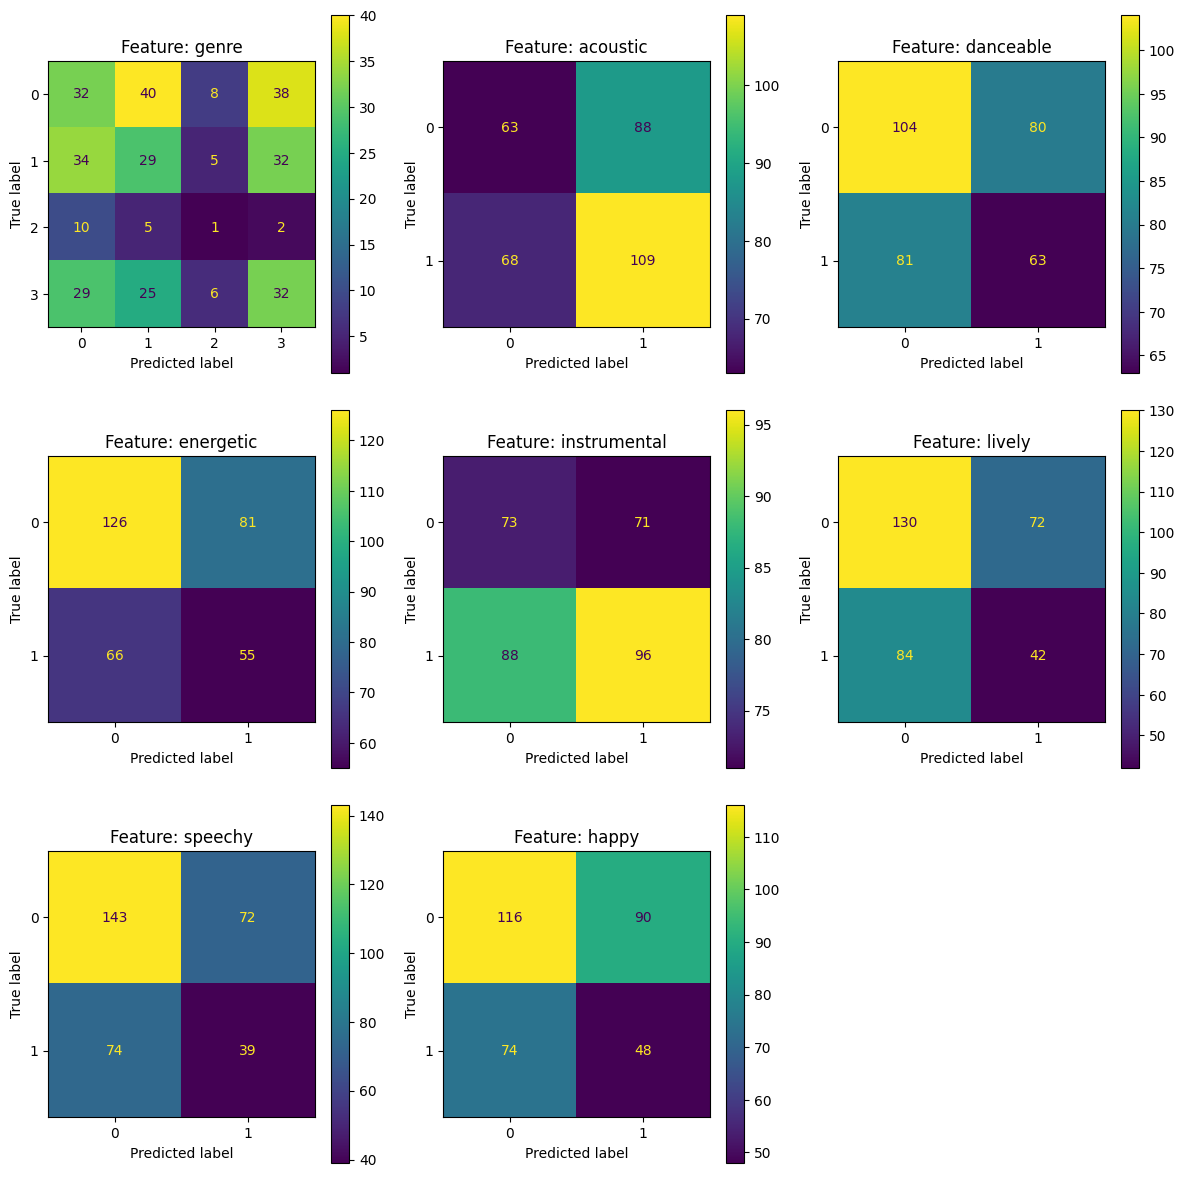

Feature Accuracies:
genre: 0.29
acoustic: 0.52
danceable: 0.51
energetic: 0.55
instrumental: 0.52
lively: 0.52
speechy: 0.55
happy: 0.50

Evaluating Mean & Std Chroma feature set using Stratified Dummy classifier:


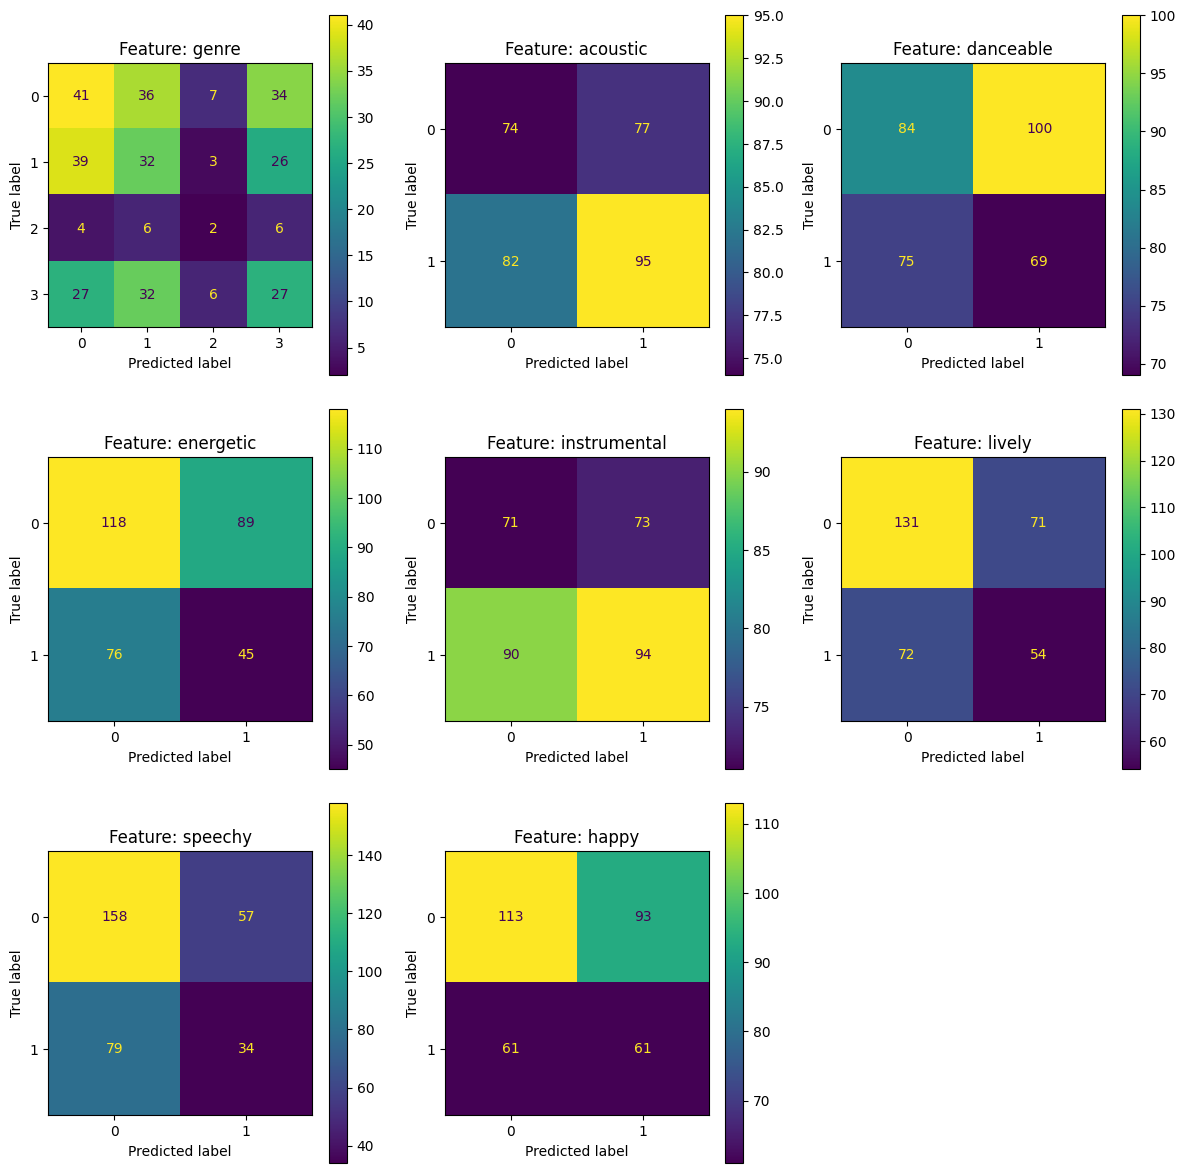

Feature Accuracies:
genre: 0.31
acoustic: 0.52
danceable: 0.47
energetic: 0.50
instrumental: 0.50
lively: 0.56
speechy: 0.59
happy: 0.53

Evaluating Mean MFCC & Chroma feature set using Stratified Dummy classifier:


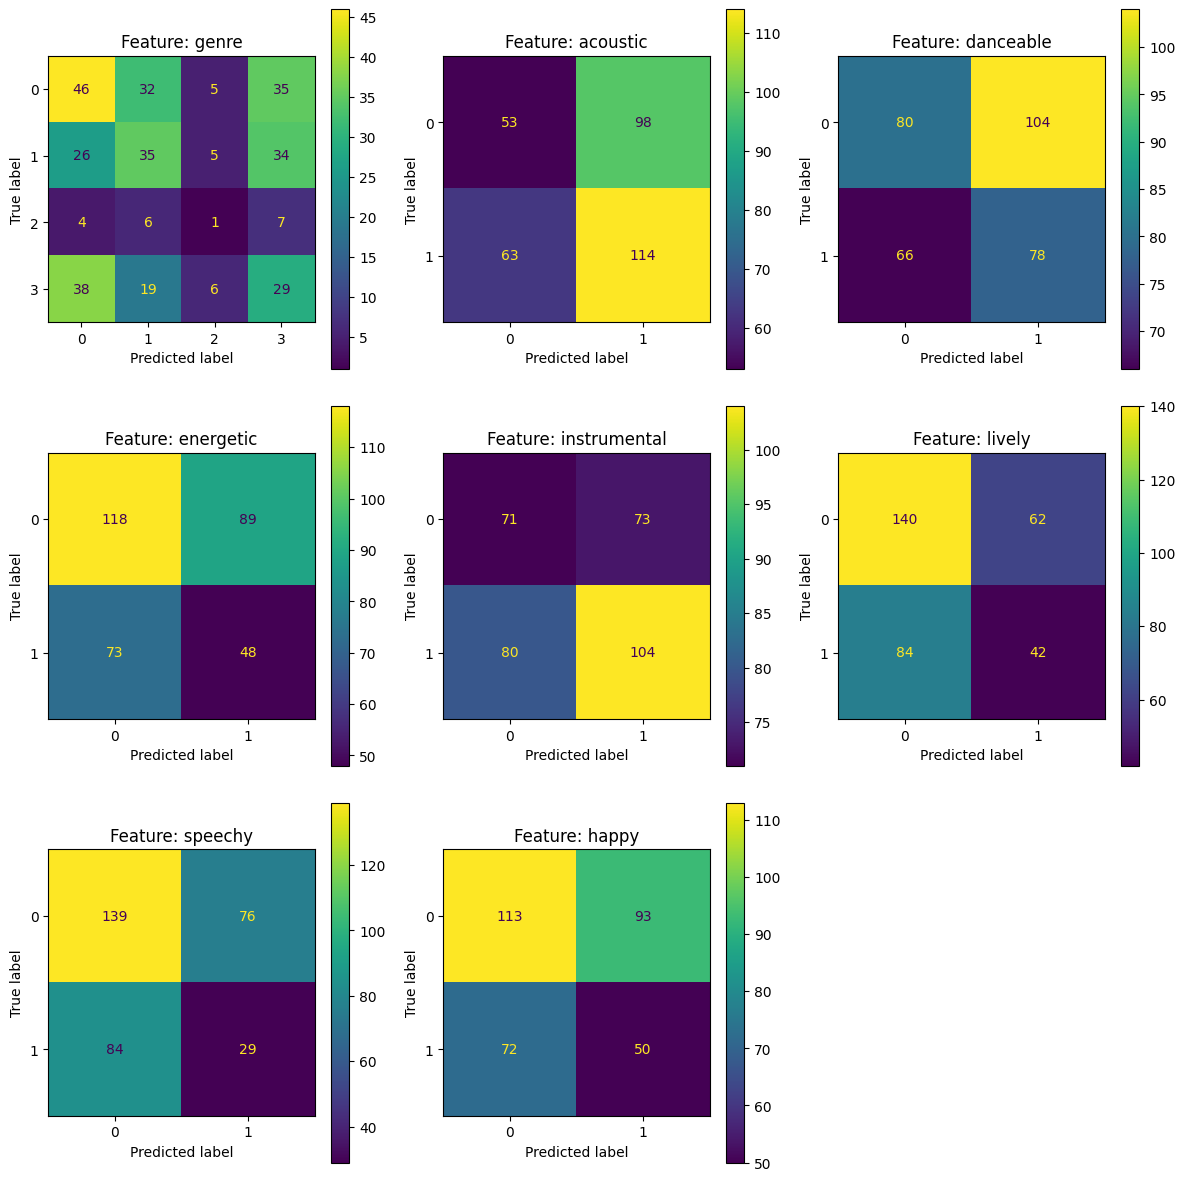

Feature Accuracies:
genre: 0.34
acoustic: 0.51
danceable: 0.48
energetic: 0.51
instrumental: 0.53
lively: 0.55
speechy: 0.51
happy: 0.50

Evaluating Tempo feature set using Stratified Dummy classifier:


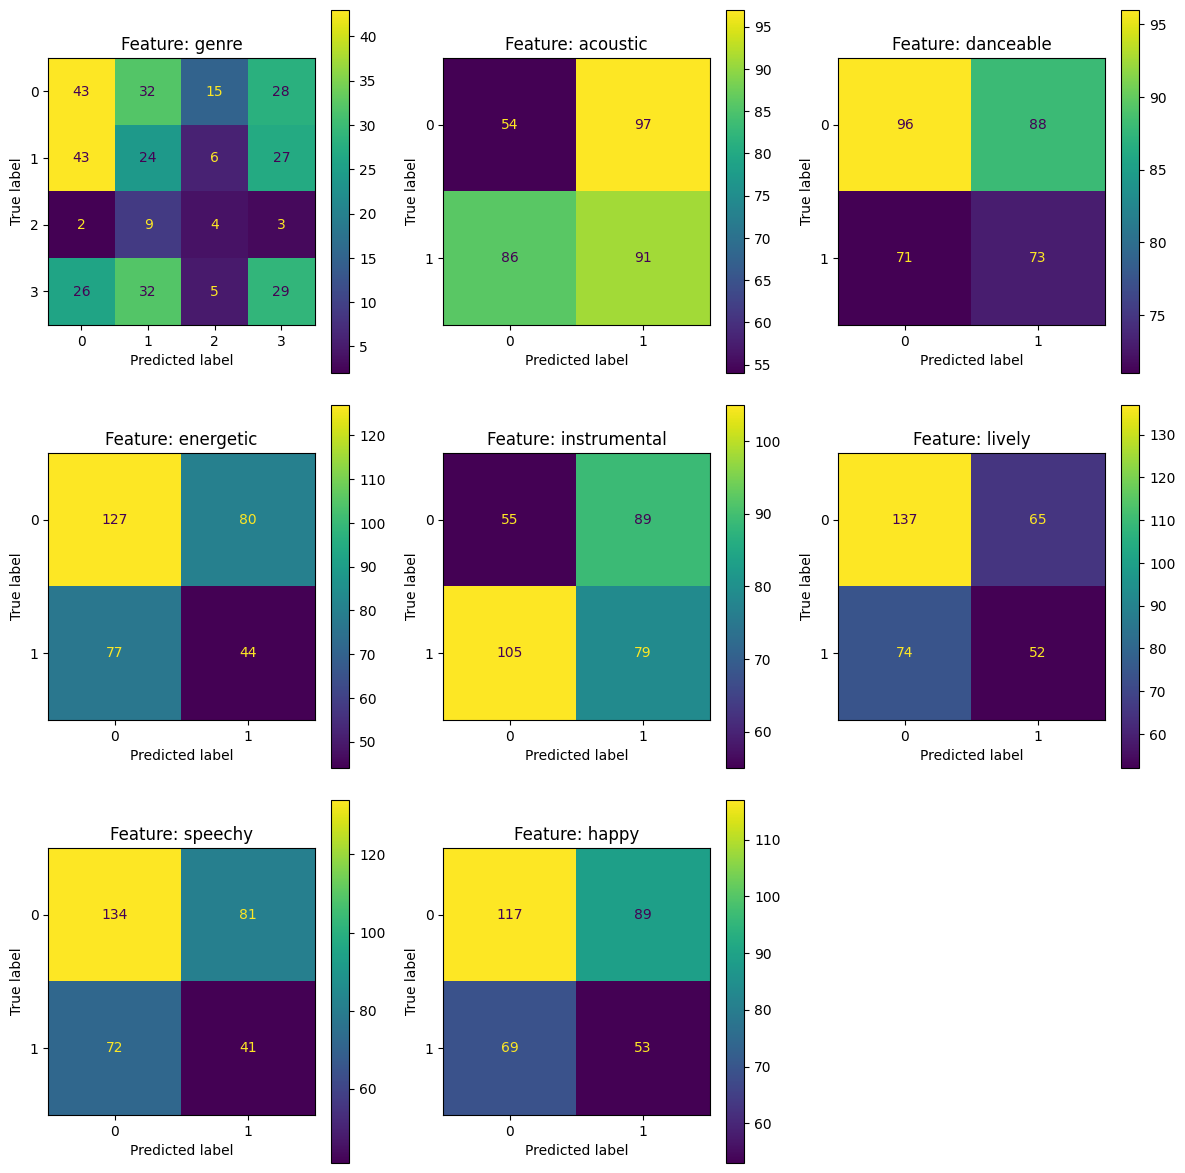

Feature Accuracies:
genre: 0.30
acoustic: 0.44
danceable: 0.52
energetic: 0.52
instrumental: 0.41
lively: 0.58
speechy: 0.53
happy: 0.52

Evaluating Mean MFCC & Tempo feature set using Stratified Dummy classifier:


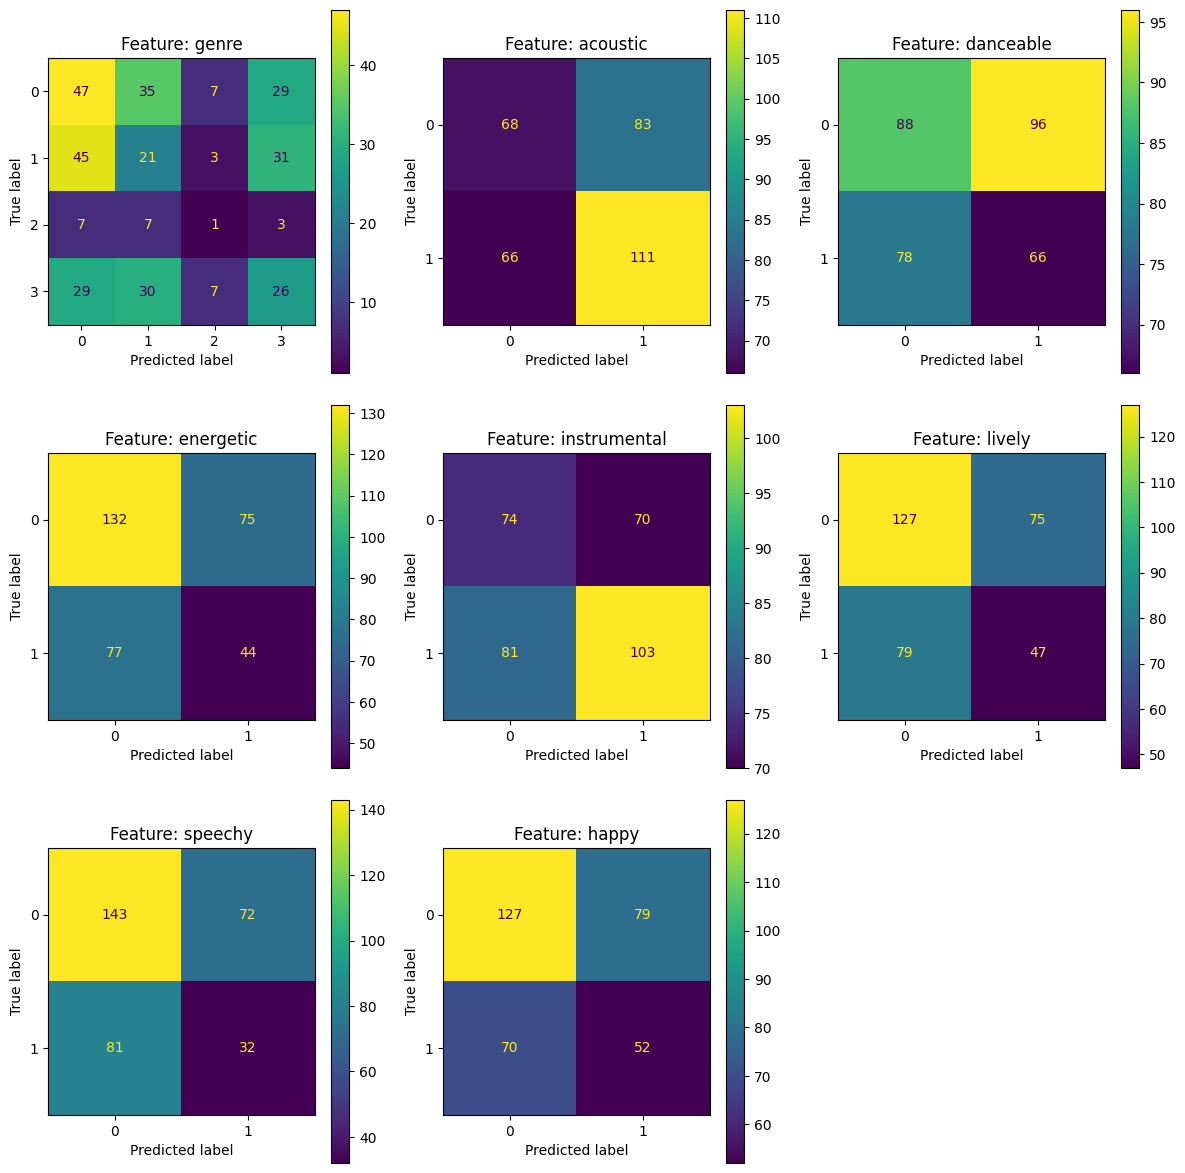

Feature Accuracies:
genre: 0.29
acoustic: 0.55
danceable: 0.47
energetic: 0.54
instrumental: 0.54
lively: 0.53
speechy: 0.53
happy: 0.55

Evaluating All Features feature set using Stratified Dummy classifier:


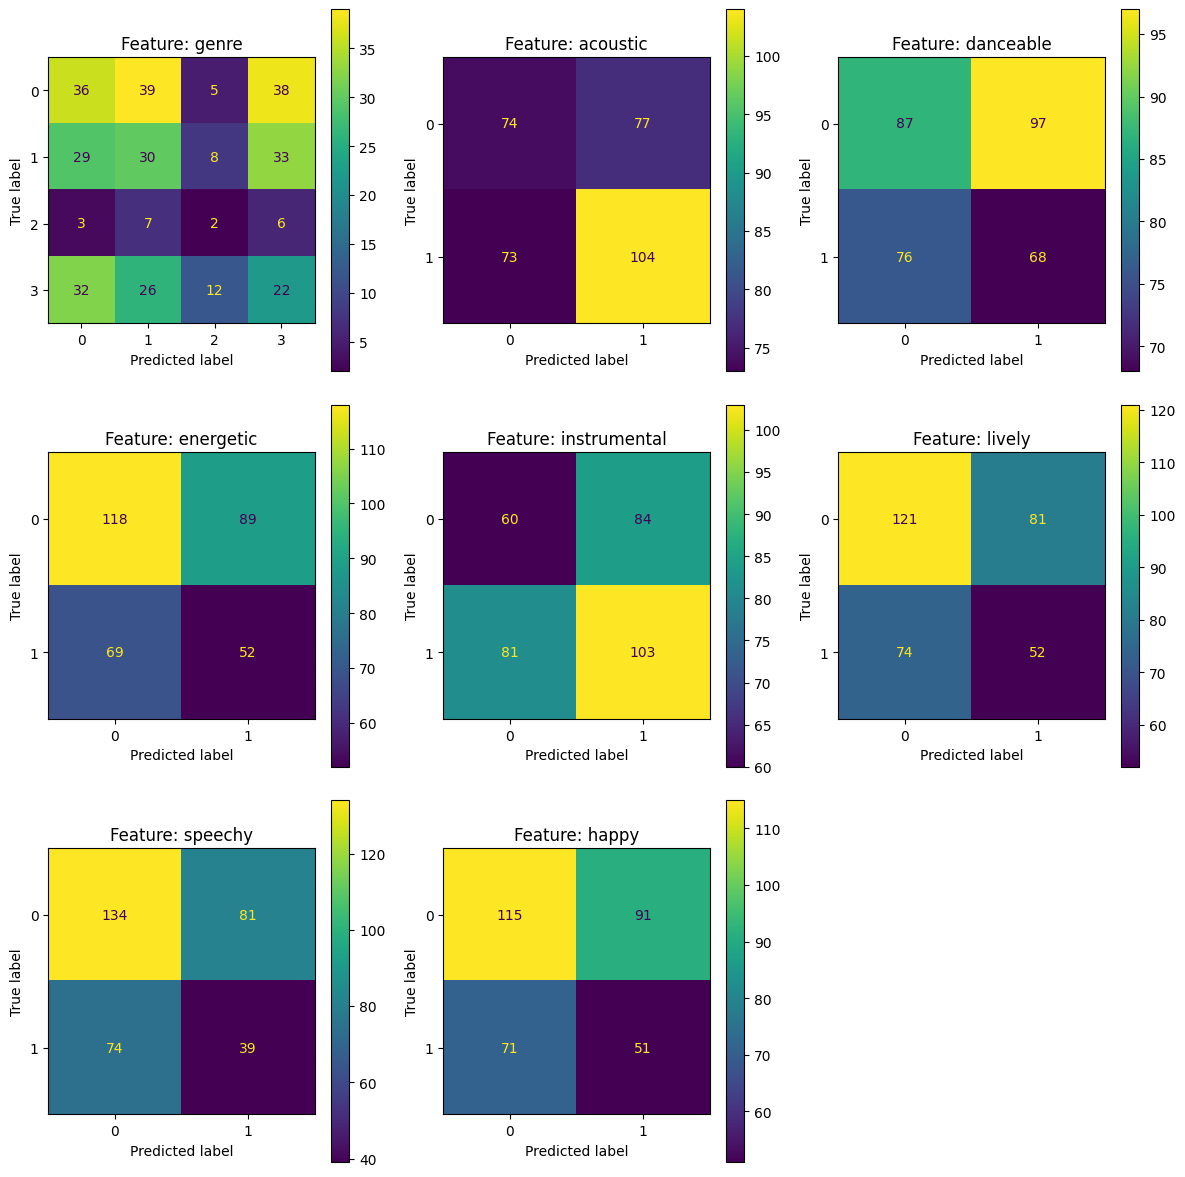

Feature Accuracies:
genre: 0.27
acoustic: 0.54
danceable: 0.47
energetic: 0.52
instrumental: 0.50
lively: 0.53
speechy: 0.53
happy: 0.51


In [122]:
# Evaluate Stratified Dummy classifier as benchmark to compare against
dummy_clf = DummyClassifier(strategy='stratified')
for feature_set, X in feature_sets.items():
    print(f"\nEvaluating {feature_set} feature set using Stratified Dummy classifier:")
    eval_classifier(X, y, dummy_clf, target_names, test_size=0.4)